In [1]:
%load_ext autoreload
%autoreload 2

import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import fake_profile as fp
import pywt
import scipy.fftpack as sf

## Simulate fake profiles, study features in CWT power spectrum due to mode changes if any

In [35]:
a1 = [3, 7, 5]
m1 = [20, 50, 70]
sd1 = [2, 2, 2]

a2 = [3, 7, 8]
m2 = [20, 50, 70]
sd2 = [2, 2, 2]

prof_a = fp.fake_profile(a1, m1, sd1); prof_a.construct_profile(noise=True, wn_sigma=.05)
prof_b = fp.fake_profile(a2, m2, sd2); prof_b.construct_profile(noise=True, wn_sigma=.05)

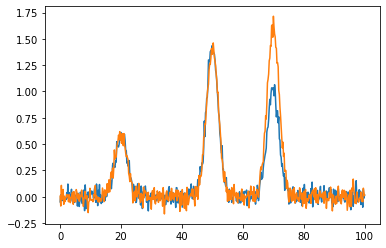

In [36]:
plt.plot(prof_a.domain, prof_a.profile, label='a')
plt.plot(prof_b.domain, prof_b.profile, label='b')

In [6]:
wavelet = pywt.Wavelet('coif3')
max_level = pywt.dwt_max_level(len(prof_a.profile), 'coif3')
coeff_a = pywt.wavedec(prof_a.profile, wavelet, mode='periodization', level=max_level)
coeff_b = pywt.wavedec(prof_b.profile, wavelet, mode='periodization', level=max_level)
max_level

4

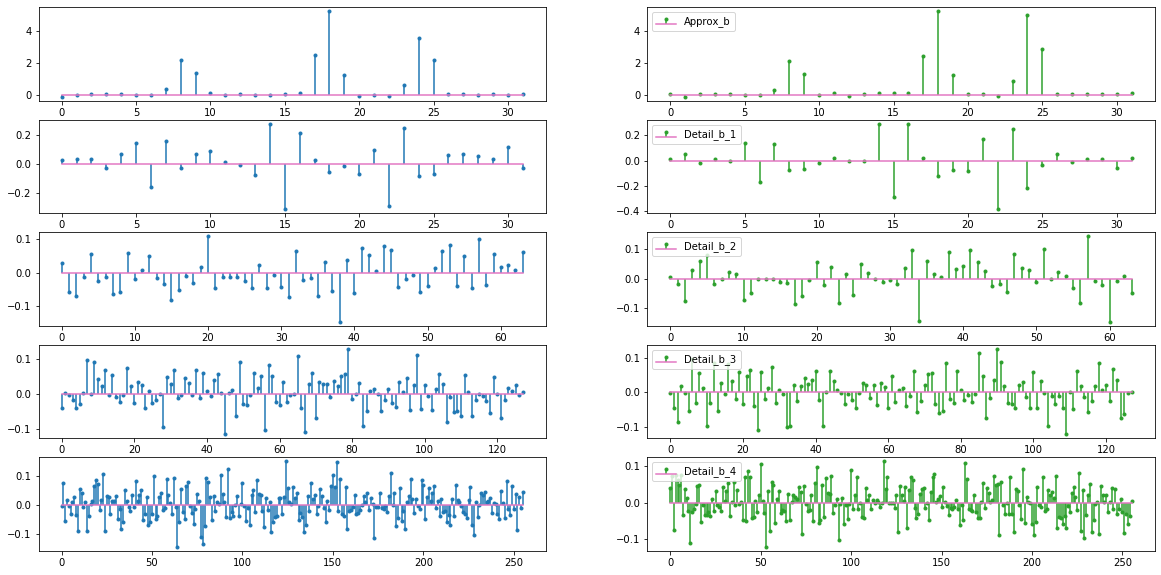

In [7]:
fig = plt.figure(figsize=(20,10))
property_a = {'linefmt': 'C0-', 'markerfmt': 'C0.', 'basefmt': 'C6-', 'use_line_collection': True}
property_b = {'linefmt': 'C2-', 'markerfmt': 'C2.', 'basefmt': 'C6-', 'use_line_collection': True}

for i in range(len(coeff_a)):
    ax1 = fig.add_subplot(5, 2, 2*i + 1)
    ax2 = fig.add_subplot(5, 2, 2*i + 2)
    if (i == 0):
        ax1.stem(coeff_a[i], **property_a, label='Approx_a')
        ax2.stem(coeff_b[i], **property_b, label='Approx_b')
    else:
        ax1.stem(coeff_a[i], **property_a, label='Detail_a_{}'.format(i))
        ax2.stem(coeff_b[i], **property_b, label='Detail_b_{}'.format(i))
    plt.legend(loc=2)

In [8]:
ign_coeff = [4] 
dcoeff = []

for i in range(len(coeff_a)):
    if i in ign_coeff:
        dcoeff.append(np.zeros(len(coeff_a[i])))
    else:
        dcoeff.append(coeff_a[i] - coeff_b[i])
dsignal = pywt.waverec(dcoeff, wavelet, mode='periodization')

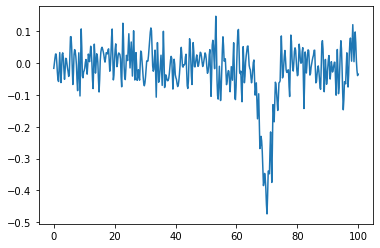

In [9]:
sns.lineplot(x=prof_a.domain, y=dsignal)

## Possible to extract just white noise, application to denoising

In [10]:
noise = []
for i in range(4):
    noise.append(np.zeros(len(coeff_b[i])))
noise.append(coeff_b[-1])
noise_sig = pywt.waverec(noise, wavelet, mode='periodization')

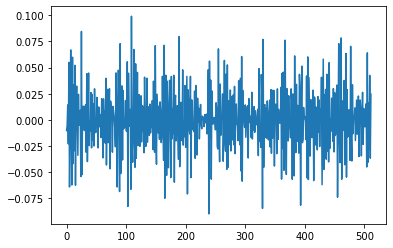

In [11]:
plt.plot(noise_sig)


## CWT Power Spectrum

In [12]:
pywt.wavelist(kind='continuous')

['cgau1',
 'cgau2',
 'cgau3',
 'cgau4',
 'cgau5',
 'cgau6',
 'cgau7',
 'cgau8',
 'cmor',
 'fbsp',
 'gaus1',
 'gaus2',
 'gaus3',
 'gaus4',
 'gaus5',
 'gaus6',
 'gaus7',
 'gaus8',
 'mexh',
 'morl',
 'shan']

In [52]:
#same template as prof_a, plus WN
prof_a_clone = fp.fake_profile(a1, m1, sd1); prof_a.construct_profile(noise=True, wn_sigma=.05)
prof_a_clone.construct_profile(noise=True)
wavelet_str = 'mexh'

coeffclone, freqclone = pywt.cwt(prof_a_clone.profile, scales=np.linspace(1, 200, 500), wavelet=wavelet_str)
coeffa, freqa = pywt.cwt(prof_a.profile, scales=np.linspace(1, 200, 500), wavelet=wavelet_str)
coeffb, freqb = pywt.cwt(prof_b.profile, scales=np.linspace(1, 200, 500), wavelet=wavelet_str)

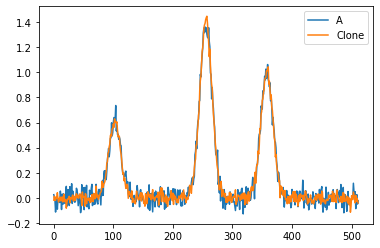

In [50]:
plt.plot(prof_a.profile, label='A')
plt.plot(prof_a_clone.profile, label='Clone')
plt.legend()
plt.show()

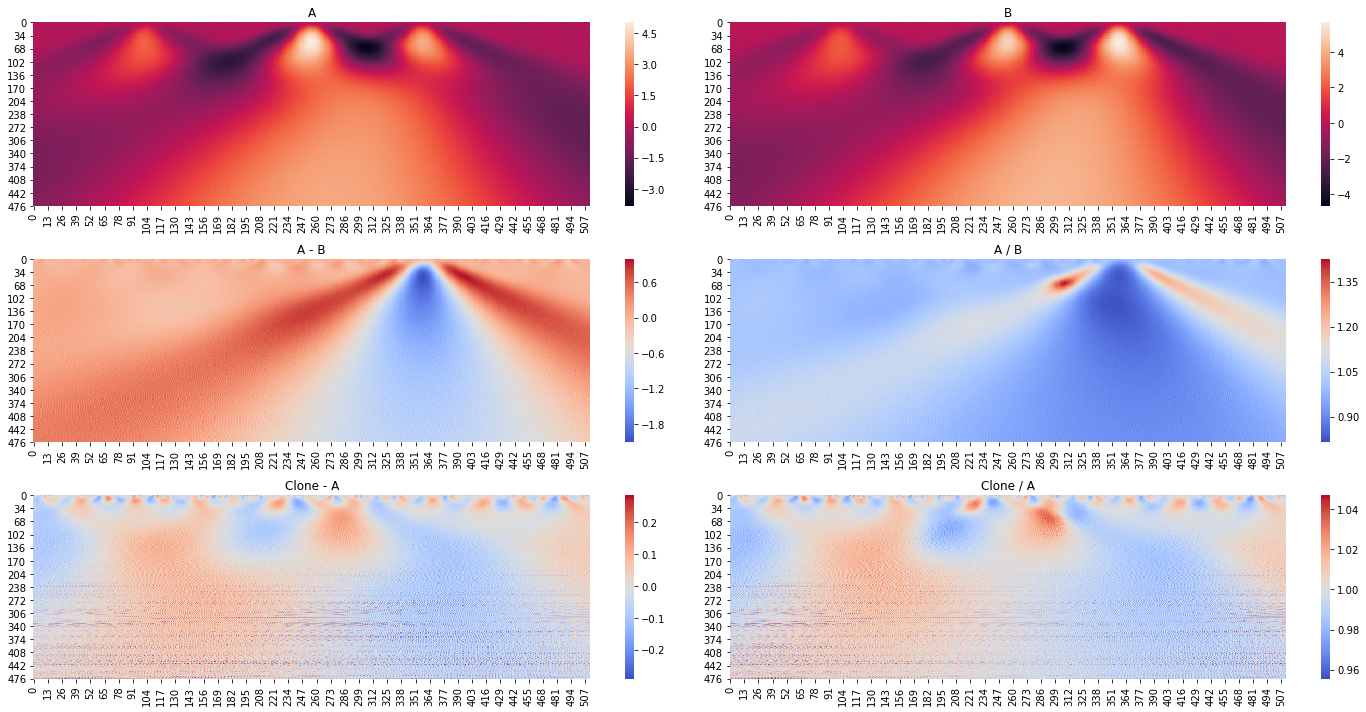

In [53]:
nrows = 3
ncols = 2
fig, ax = plt.subplots(nrows, ncols, figsize=(20, 10))

offset = np.max([np.abs(coeffa.min()), np.abs(coeffa.max()), np.abs(coeffb.min()), np.abs(coeffb.max())])
offset += 1
ratioab = (coeffa+offset) / (coeffb+offset)

offset = np.max([np.abs(coeffa.min()), np.abs(coeffa.max()), np.abs(coeffclone.min()), np.abs(coeffclone.max())])
offset += 1
ratioclone = (coeffclone+offset) / (coeffa+offset) 

data = [coeffa, coeffb, coeffa-coeffb, ratioab, coeffclone-coeffa, ratioclone]
titles = ['A', 'B', 'A - B', 'A / B', 'Clone - A', 'Clone / A']
seq = sns.light_palette('green', 100)
div = sns.color_palette("coolwarm", 100) #sns.color_palette("RdBu_r", 7) #sns.color_palette("BrBG", 7) 
cmaps = [None ,None , div, div, div, div]

ct = 0
for r in range(nrows):
    for c in range(ncols):
        sns.heatmap(data[ct], ax=ax[r][c], cmap=cmaps[ct])
        ax[r][c].set_title(titles[ct])
        ct += 1
plt.tight_layout()
plt.savefig('./power_spectrum/fake_ps_mexh_pk3.jpeg')

In [209]:
#some kind of significance testing to see if ratio value is sig or not?